In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform, exposure
from skimage.measure import label, regionprops
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import time
import cv2


2025-05-14 12:07:02.848097: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747204623.169736    4630 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747204623.241394    4630 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747204623.794583    4630 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747204623.794665    4630 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747204623.794673    4630 computation_placer.cc:177] computation placer alr

In [ ]:
# Constants
IMAGE_SIZE = 4418  # Reduced size for manageable training
BATCH_SIZE = 8
EPOCHS = 30


In [3]:
def load_and_preprocess_data(raw_images_path, reference_images_path):
    """
    Load and preprocess 16-bit grayscale satellite images and corresponding binary reference masks.
    Returns NumPy arrays for input (X) and target (y).
    """
    X = []  # To store raw input images
    y = []  # To store corresponding binary ground truth images
    
    # Collect all image filenames with .tiff and .jpeg extensions
    raw_files = sorted([f for f in os.listdir(raw_images_path) if f.endswith('.tiff')])
    ref_files = sorted([f for f in os.listdir(reference_images_path) if f.endswith('.jpeg')])
    
    for raw_file, ref_file in zip(raw_files, ref_files):
        # Load 16-bit raw satellite image
        raw_img = io.imread(os.path.join(raw_images_path, raw_file))
        
        # Load reference image (mask), convert to grayscale if it's RGB
        ref_img = io.imread(os.path.join(reference_images_path, ref_file))
        if len(ref_img.shape) == 3:  # If the image has 3 channels (RGB)
            ref_img = cv2.cvtColor(ref_img, cv2.COLOR_RGB2GRAY)
        
        # Resize both images to a fixed size (256x256) for uniformity
        raw_img = transform.resize(raw_img, (IMAGE_SIZE, IMAGE_SIZE), anti_aliasing=True)
        ref_img = transform.resize(ref_img, (IMAGE_SIZE, IMAGE_SIZE), anti_aliasing=True)
        
        # Normalize raw image to range [0, 1]
        raw_img = exposure.rescale_intensity(raw_img, out_range=(0, 1))
        
        # Binarize the reference image: convert to 0 or 1 (mask)
        ref_img = (ref_img > 0.5).astype(np.float32)
        
        # Store processed images
        X.append(raw_img)
        y.append(ref_img)
    
    return np.array(X), np.array(y)


In [4]:
def create_model(input_shape):
    """
    Build a convolutional neural network (CNN) for binary segmentation of streaks/stars.
    This uses an encoder-decoder (autoencoder-like) architecture.
    """
    model = models.Sequential([
        # Encoder: Downsampling blocks
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Decoder: Upsampling blocks (like UNet-style decoder)
        layers.Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same'),
        layers.BatchNormalization(),

        layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same'),
        layers.BatchNormalization(),

        layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same'),
        layers.BatchNormalization(),

        # Output layer: 1-channel prediction mask using sigmoid
        layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')
    ])

    # Compile the model using binary cross-entropy (for binary masks)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


In [5]:
def detect_objects(pred_mask, min_area=10):
    """
    Process predicted mask to detect objects and classify them as stars or streaks
    based on eccentricity. Returns a list of object details.
    """
    # Label connected components (regions) in the binary prediction
    labeled = label(pred_mask > 0.5)  # Threshold the mask to get binary image
    regions = regionprops(labeled)   # Extract properties of labeled regions
    
    objects = []  # List to store detected object info

    for region in regions:
        if region.area >= min_area:  # Filter out small noise
            # Use eccentricity to classify type:
            # High eccentricity → stretched → streak, else star
            if region.eccentricity > 0.9:
                obj_type = "streak"
            else:
                obj_type = "star"

            # Add object info to the list
            objects.append({
                "type": obj_type,
                "centroid": region.centroid[::-1],  # (row, col) → (x, y)
                "area": region.area,
                "eccentricity": region.eccentricity
            })

    return objects


In [6]:
def main():
    # Paths to dataset folders
    raw_images_path = "Datasets/Raw_Images"
    reference_images_path = "Datasets/Reference_Images"

    # Step 1: Load and preprocess data
    print("Loading and preprocessing data...")
    X, y = load_and_preprocess_data(raw_images_path, reference_images_path)

    # Step 2: Add channel dimension (needed for CNN input)
    X = np.expand_dims(X, axis=-1)
    y = np.expand_dims(y, axis=-1)

    # Step 3: Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Step 4: Data augmentation setup to avoid overfitting
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    )

    # Step 5: Create model
    model = create_model((IMAGE_SIZE, IMAGE_SIZE, 1))
    print(model.summary())

    # Step 6: Train model with augmented data
    print("Training model...")
    start_time = time.time()

    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
        steps_per_epoch=len(X_train) // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_test, y_test)
    )

    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")

    # Step 7: Evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print(f"\nTest accuracy: {test_acc:.4f}")

    # Step 8: Save trained model
    model.save("streak_star_detector.h5")

    # Step 9: Visualize prediction on one test image
    sample_idx = 0
    sample_img = X_test[sample_idx]
    sample_mask = y_test[sample_idx]

    pred_mask = model.predict(np.expand_dims(sample_img, axis=0))[0]

    # Step 10: Postprocessing – detect objects in prediction
    detected_objects = detect_objects(pred_mask[:, :, 0])

    # Step 11: Visualization – show original, ground truth, and prediction
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(sample_img[:, :, 0], cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(sample_mask[:, :, 0], cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Prediction with Detections")
    pred_display = np.zeros((IMAGE_SIZE, IMAGE_SIZE, 3))
    pred_display[:, :, 0] = pred_mask[:, :, 0]  # Red channel = prediction

    # Draw detected objects with colored dots
    for obj in detected_objects:
        color = (0, 1, 0) if obj["type"] == "star" else (0, 0, 1)  # Green for stars, Blue for streaks
        centroid = tuple(map(int, obj["centroid"]))
        cv2.circle(pred_display, centroid, 3, color, -1)
        plt.text(centroid[0]+5, centroid[1]+5, obj["type"], color='white', fontsize=8)

    plt.imshow(pred_display)
    plt.show()

    # Step 12: Print out detected object properties
    print("\nDetected Objects:")
    for i, obj in enumerate(detected_objects):
        print(f"Object {i+1}:")
        print(f"  Type: {obj['type']}")
        print(f"  Centroid (x, y): {obj['centroid']}")
        print(f"  Area: {obj['area']} pixels")
        print(f"  Eccentricity: {obj['eccentricity']:.2f}")

    # Step 13: Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.show()


Loading and preprocessing data...


/home/harsh/Downloads/Python-3.12.6/arctan/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-14 12:11:46.363192: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 512, 512, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512, 512, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 128, 128, 128)  │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 256, 256, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 512, 512, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512, 512, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 512, 512, 1)    │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 334,337 (1.28 MB)

 Trainable params: 333,441 (1.27 MB)

 Non-trainable params: 896 (3.50 KB)

None
Training model...


/home/harsh/Downloads/Python-3.12.6/arctan/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


2025-05-14 12:12:02.905074: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.
2025-05-14 12:12:03.527702: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.
2025-05-14 12:12:04.047803: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.
2025-05-14 12:12:08.051621: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.
2025-05-14 12:12:09.274878: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.


3/3 ━━━━━━━━━━━━━━━━━━━━ 74s 18s/step - accuracy: 0.5207 - loss: 0.7550 - val_accuracy: 0.9992 - val_loss: 0.6923
Epoch 2/30
1/3 ━━━━━━━━━━━━━━━━━━━━ 41s 21s/step - accuracy: 0.5087 - loss: 0.7296

/home/harsh/Downloads/Python-3.12.6/arctan/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.5087 - loss: 0.7296 - val_accuracy: 0.9993 - val_loss: 0.6920
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 69s 23s/step - accuracy: 0.5060 - loss: 0.7335 - val_accuracy: 0.9993 - val_loss: 0.6910
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.5158 - loss: 0.7343 - val_accuracy: 0.9993 - val_loss: 0.6907
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 69s 23s/step - accuracy: 0.5170 - loss: 0.7208 - val_accuracy: 0.9993 - val_loss: 0.6898
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.5311 - loss: 0.7126 - val_accuracy: 0.9993 - val_loss: 0.6894
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 57s 18s/step - accuracy: 0.5254 - loss: 0.7114 - val_accuracy: 0.9993 - val_loss: 0.6884
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.5215 - loss: 0.7114 - val_accuracy: 0.9993 - val_loss: 0.6881
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 67s 23s/step - accuracy: 0.5370 - loss: 0.7091 - val_accuracy: 0.9993 - val_loss: 0.6872
Epoch 10/30
3/3


Test accuracy: 0.9993
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


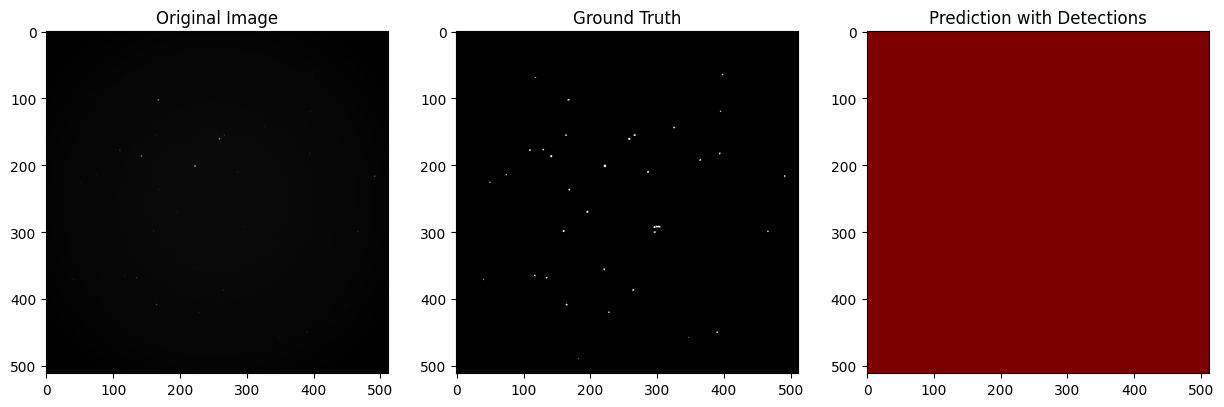


Detected Objects:


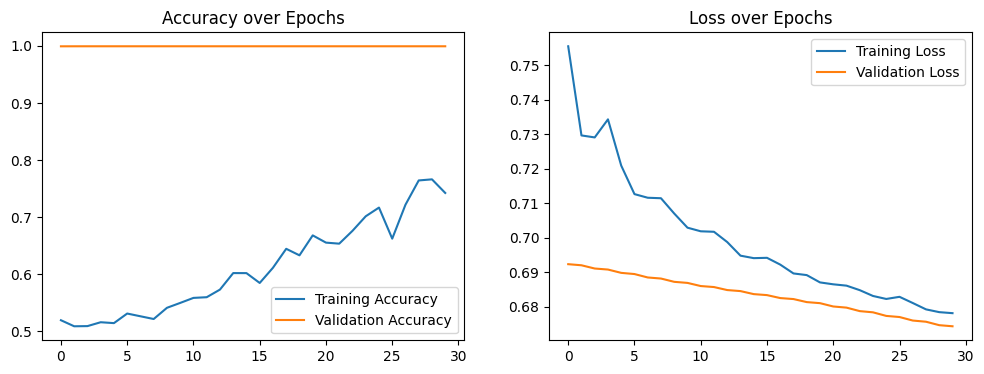

In [7]:
if __name__ == "__main__":
    main()
